# [IAPR][iapr]: Lab 1 ‒  Image segmentation


**Group ID:** 22

**Author 1:** Alexander Pisarewski (26689)  
**Author 2 (sciper):** Guillaume Champain (xxxxx)   
**Author 3 (sciper):** Adrien AMOROS (xxxxx)   

**Release date:** 12.03.2021  
**Due date:** 26.03.2021 


## Important notes

The lab assignments are designed to teach practical implementation of the topics presented during class well as preparation for the final project, which is a practical project which ties together the topics of the course. 

As such, in the lab assignments/final project, unless otherwise specified, you may, if you choose, use external functions from image processing/ML libraries like opencv and sklearn as long as there is sufficient explanation in the lab report. For example, you do not need to implement your own edge detector, etc.

**! Before handling back the notebook !** rerun the notebook from scratch `Kernel` > `Restart & Run All`


[iapr]: https://github.com/LTS5/iapr

---
## 0. Extract relevant data
We first need to extract the `lab-01-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [1]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-01-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')

if not os.path.exists(tar_path):
    raise Exception('Path to is not valid {}'.format(tar_path))
    
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

---
## Part 1: Brain segmentation

Your goal: compute the size of the brain (without the skull) in pixels in a 2D image of a human head taken by Magnetic Resonance Imaging (MRI) using:
* Region growing (5 pts)
* Contour detection (5 pts)
* Additional method of your choice (5 pts)

Each section should display the resulting segmenttion as well as the size in pixel of the detected region. Comment each method limitations and/or advantages.

### 1.1 Brain image visualization

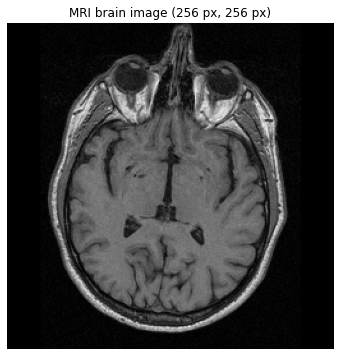

In [2]:
import skimage.io
import skimage.measure
import skimage.filters
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
%matplotlib inline

# Load image
data_path = os.path.join(data_base_path, data_folder)
brain_im = skimage.io.imread(os.path.join(data_path, 'brain-slice40.tiff'))
im_h, im_w = brain_im.shape

# Display MRI image
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(brain_im, cmap='gray')
ax.set_title('MRI brain image ({} px, {} px)'.format(im_h, im_w))
ax.axis('off')
plt.show()

### 1.2 Region growing (5pts)

region : 
 (0, 2)


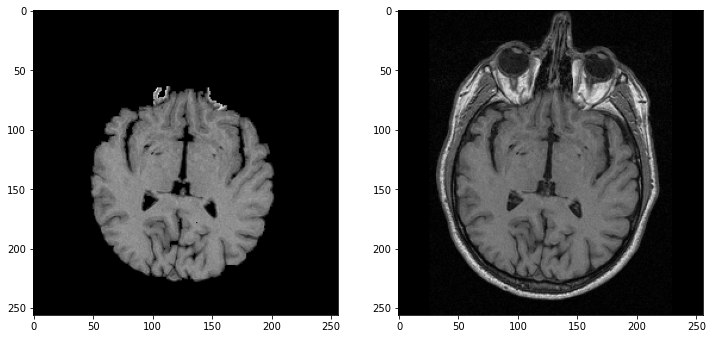

In [5]:
# Add your implementation and discussion
length=brain_im.shape[0]
sample=brain_im[130:150,140:160]
brain_copy=brain_im.copy()
#brain_copy=skimage.filters.gaussian(brain_copy,sigma=0.5)

#Homogeinity criterion based on two thresholds t_l<x<t_h
thresh=np.mean(sample)*0.6
thresh2=np.mean(sample)*1.1
mask=brain_im>thresh
#brain_copy[mask]=255

#Try
start=[200,125]
region=[start]
Exploring_map=np.zeros((length,length))
Exploring_map[start[0],start[1]]=2
process=True

while process :
    for pixel in region:
        X,Y = np.mgrid[pixel[0]-1:pixel[0]+2,pixel[1]-1:pixel[1]+2]#Find surrounding pixels
        Xsurr,Ysurr=np.vstack((X.ravel(), Y.ravel())) 
        Surr=np.vstack((Xsurr,Ysurr)).T #Making array with surrounding pixels coordinates
        for exp in Surr :
            if Exploring_map[exp[0],exp[1]] == 0: # If never explored
                if brain_copy[exp[0],exp[1]]>thresh and brain_copy[exp[0],exp[1]]<thresh2 : #If in range for brain
                    Exploring_map[exp[0],exp[1]] = 2
                else:
                    Exploring_map[exp[0],exp[1]] = 1 # If never explored and not in threshold
            elif Exploring_map[exp[0],exp[1]] ==2:# If already inquired, try once more for pixels around
                Exploring_map[exp[0],exp[1]]=3
            elif Exploring_map[exp[0],exp[1]] ==3:# If already inquired, exclude from next pixels to explore
                Exploring_map[exp[0],exp[1]]=4    
                
    region=np.vstack((np.where((Exploring_map==2)|(Exploring_map==3)))).transpose()
    #print(region)
    if region.shape[0]==0:
        process = False
    
mask=Exploring_map<1
print('region : \n',region.shape)
brain_copy[mask]=0 #See the whole brain region

# Display Images of the brain
fig, ax = plt.subplots(1, 2, figsize=(12, 7))
ax[0].imshow(brain_copy, cmap='gray')
ax[1].imshow(brain_im, cmap='gray')
plt.show()



### 1.3 Contour detection (5pts)

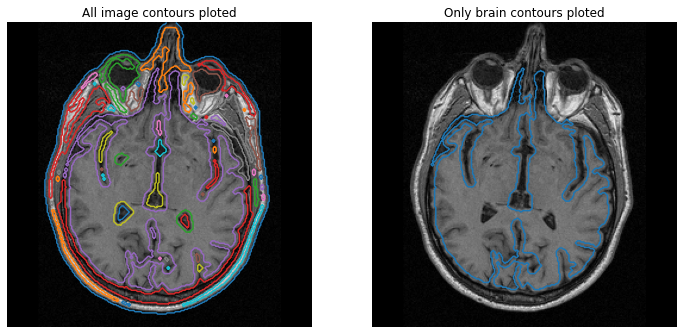

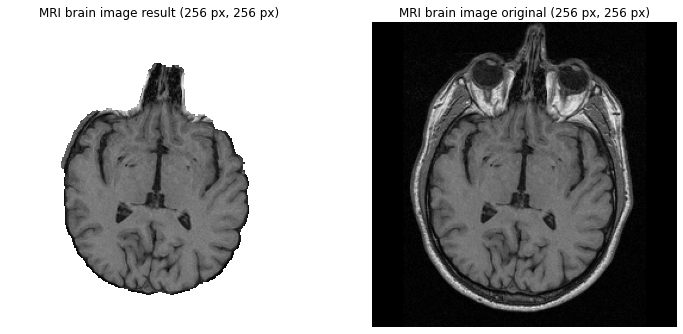

In [5]:
from skimage import measure,feature
from skimage.morphology import disk, dilation, opening, closing
from skimage.draw import polygon
import numpy as np

def gaussian_kernel(l, sig):
    #creates gaussian kernel with side length l and a sigma of sig
    ax = np.linspace(-(l - 1) / 2., (l - 1) / 2., l)
    xx, yy = np.meshgrid(ax, ax)

    kernel = np.exp(-0.5 * (np.square(xx) + np.square(yy)) / np.square(sig))

    return kernel / np.sum(kernel)

#blurred_im = ndimage.filters.convolve(brain_im,gaussian_kernel(5,2))

#Canny edge detection to highlight image edges
canny_edges = feature.canny(brain_im, sigma=2)

#Morphology transformation to simply contours detecttion
base_shape = disk(1)
dilated_canny= dilation(canny_edges,base_shape)
closed_canny = closing(dilated_canny,base_shape)

#contours image
contours_canny=measure.find_contours(closed_canny,0.2)

brain_contours = max(contours_canny, key=len) #the brain contours is the longest

#Display images result comparison
fig, ax = plt.subplots(1, 2, figsize=(12, 12))
ax[0].imshow(brain_im, cmap='gray')
for contour in contours_canny:
    ax[0].plot(contour[:, 1], contour[:, 0], linewidth=1.5)
ax[0].set_title('All image contours ploted')
ax[0].axis('off')
ax[1].imshow(brain_im, cmap='gray')
ax[1].plot(brain_contours[:, 1], brain_contours[:, 0], linewidth=1.5)
ax[1].set_title('Only brain contours ploted')
ax[1].axis('off')
plt.show()

#create a mask to extract brain pixels within contours
mask = np.zeros(brain_im.shape)
rr, cc = polygon(brain_contours[:, 0], brain_contours[:, 1], mask.shape)
mask[rr, cc] = 1

#Morphology processing to fill the hole and get as best as possible the brain
base_shape = disk(5)
dilated_mask = dilation(mask,base_shape)
opened_mask = opening(dilated_mask,base_shape)
closed_mask = closing(opened_mask,base_shape)

closed_mask = np.logical_not(closed_mask)#keep the mask's original values 

result_image_closed = np.ma.array(brain_im.copy(), mask=closed_mask)

#Display images result comparison
fig, ax = plt.subplots(1, 2, figsize=(12, 12))
ax[0].imshow(result_image_closed, cmap='gray')
ax[0].set_title('MRI brain image result ({} px, {} px)'.format(im_h, im_w))
ax[0].axis('off')
ax[1].imshow(brain_im, cmap='gray')
ax[1].set_title('MRI brain image original ({} px, {} px)'.format(im_h, im_w))
ax[1].axis('off')
plt.show()

### 1.4 Additional method: Region Splitting (5pts)

In [3]:
#First we create an object Region that encapuslats several features of every region
class Region: 
    def __init__(self, lower_left_x, lower_left_y, upper_right_x, upper_right_y):  
        

        #The coordinates of the corners of the region
        self.lower_left_x= lower_left_x
        self.lower_left_y = lower_left_y
        self.upper_right_x=upper_right_x
        self.upper_right_y=upper_right_y 
        
        
    def homog(self):#homogeneity condition
        
        mm=brain_im[self.lower_left_x:self.upper_right_x,
                  self.lower_left_y:self.upper_right_y]
        m=mm.mean()
        if m>thresh and m<thresh2: #check if it belongs to the brain
            #print('m1:',m)
            return 1
        elif m<10:  #check if its black
            #print('m2:',m)
            return 2
        else:
            return 3
    def mean(self):
        mm=brain_im[self.lower_left_x:self.upper_right_x,
                  self.lower_left_y:self.upper_right_y]
        return mm.mean()
        
    def size(self):# returns the length of the largest side of the region
        xl=self.lower_left_x;
        yl=self.lower_left_y;
        xr=self.upper_right_x;
        yr=self.upper_right_y;
        return max([xr-xl,yr-yl])
    
    def split(self): # determines weather to split the region horizontally or vertically
        xl=self.lower_left_x; yl=self.lower_left_y; xr=self.upper_right_x; yr=self.upper_right_y;
        if [xr-xl]>=[yr-yl]:
            return False
        else: 
            return True
        

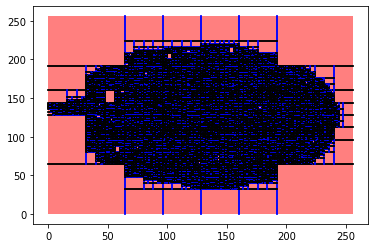

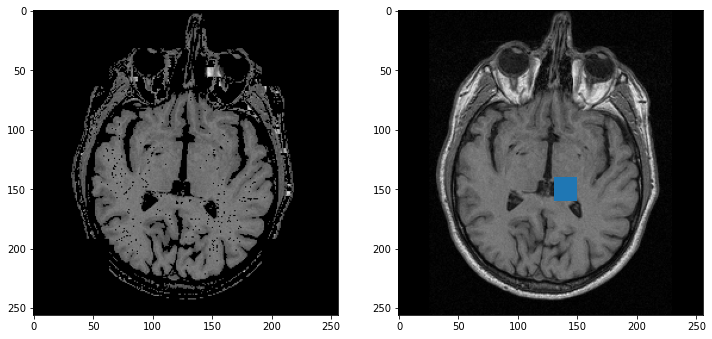

The area of the brain is given by:  20845.0  pixels


In [20]:
####Parameters #####
length=brain_im.shape[0]
brain_copy=brain_im.copy()
sample=brain_im[130:150,140:160]
thresh=np.mean(sample)*1.1
thresh2=np.mean(sample)*1.11

label_map=np.zeros(brain_im.shape)
list=[] #creation of the list
list.append(Region(0,0,brain_im.shape[0],brain_im.shape[1])) # addition of the image as first region
count=0

#### Visualisation ####
rect=Rectangle((0,0),brain_im.shape[0],brain_im.shape[1],facecolor='r',edgecolor='None', alpha=0.5)
fig, ax = plt.subplots()
ax.add_patch(rect)



#### Start of the algorithm ####
while len(list)>0 and count<=100: #while the list of regions is not empty 
    for region in list:      
        list.remove(region) #we remove the analysed region from the list
        if region.homog()==1: # if region satisfies homogeity condition 
            #print("1")
            label_map[region.lower_left_x:region.upper_right_x,
                      region.lower_left_y:region.upper_right_y]=1 # 1 is in Brain
        elif region.homog()==2: # if region is black or research region is small it is considered as no brain
            #print("2")
            label_map[region.lower_left_x:region.upper_right_x,
                      region.lower_left_y:region.upper_right_y]=0 #0 is out of brain
        elif region.size()<2:    
            if region.mean()<= thresh:
                if thresh-region.mean()<region.mean()-10:
                    label_map[region.lower_left_x:region.upper_right_x,
                      region.lower_left_y:region.upper_right_y]=1 # 1 is in Brain
                else:
                    label_map[region.lower_left_x:region.upper_right_x,
                      region.lower_left_y:region.upper_right_y]=0 # 1 is not in Brain
            elif region.mean()>=1.1*thresh2:
                label_map[region.lower_left_x:region.upper_right_x,
                      region.lower_left_y:region.upper_right_y]=0 # 1 is notin Brain                
        else: # if the considered region its not defined, it gets split            
            #print("3")
            xl=region.lower_left_x;
            yl=region.lower_left_y;
            xr=region.upper_right_x;
            yr=region.upper_right_y;
            horizontal=region.split()
            if horizontal: #the split is either horizontal (50% of the time)
                #print("4")
                region1=Region(xl,yl,xr,round(yl+(yr-yl)/2))
                region2=Region(xl,round(yl+(yr-yl)/2),xr,yr)
                
                ax.plot([region2.lower_left_x ,region2.upper_right_x],
                        [region2.lower_left_y, region2.lower_left_y], color='black')
                ax.plot([region1.lower_left_x ,region1.upper_right_x],
                        [region1.upper_right_y, region1.upper_right_y], color='black')
                
            else: #the split can also be vertical 
                #print("5")     
                region1=Region(xl,yl,round(xl+(xr-xl)/2),yr) 
                region2=Region(round(xl+(xr-xl)/2),yl,xr,yr)
                
                ax.plot([region2.lower_left_x ,region2.lower_left_x],
                      [region2.lower_left_y, region2.upper_right_y],color='blue')
                ax.plot([region1.upper_right_x ,region1.upper_right_x],
                       [region1.lower_left_y, region1.upper_right_y],color='blue')
     
            list.append(region1) 
            list.append(region2)
    count+=1
plt.show()   



#### Visualization #####

brain_dedieu=np.multiply(brain_im,label_map,)
# Display Images of the brain
fig, ax = plt.subplots(1, 2, figsize=(12, 7))
ax[0].imshow(brain_dedieu, cmap='gray')
ax[1].imshow(brain_im, cmap='gray')
rect1=Rectangle((130,140),20,20)
ax[1].add_patch(rect1)
plt.show()


#### Amount of pixels in brain #####
px_num=label_map.sum().sum()
print('The area of the brain is given by: ', px_num,' pixels')

### Conclusion for region splitting 
We can notice that this method does not allow to isolate the brain but takes into account all reginos that have approximately the same intensity. Which explains the high amount of pixels that are classified in the brain.
We can conclude that this method can be appropriate to isolate object which present high gradients of intensity, with respect to the back ground, but is less powerful for images with low graidents just like this brain image. 


---
## Part 2: Shape/color segmentation

You will find hereafter three pictures taken under three different illuminations, containing some shapes with different colors. We ask you to create a routine to:

1. Count the number of shapes of each color (5pts).
2. Compute the total area (in pixels) of each color (5pts).

Please note that one specific challenge is to be robust to illumination changes. Therefore some kind of intensity normalization should probably be used.

### 2.1 Visualization

In [ ]:
# Load images
im_names = ['arena-shapes-01', 'arena-shapes-02', 'arena-shapes-03']
filenames = [os.path.join(data_path, name) + '.png' for name in im_names]
ic = skimage.io.imread_collection(filenames)
images = skimage.io.concatenate_images(ic)
print('Number of images: ', images.shape[0])
print('Image size: {}, {} '.format(images.shape[1], images.shape[2]))
print('Number of color channels: ', images.shape[-1])

In [ ]:
# Plot images
fig, axes = plt.subplots(1, 3, figsize=(12, 12))
for ax, im, nm in zip(axes.ravel(), images, im_names):
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(nm)
plt.show()

### 2.2 Number of shapes of each color (5 pts)

In [ ]:
# Add your implementation and discussion

### 2.3 Total area (in pixels) of each color (5 pts)

In [ ]:
# Add your implementation and discussion